In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [9]:
proj_name = "benchmark_summary"

file_suffix = time.strftime('%b%d-%H%M')
data_dir = Path(f"../data/{proj_name}")
save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

### Metrics profiling

In [21]:
metrics_paths = {
    "GTEX v9": data_dir / "summary_metrics_integration/benchmark_cross_tissue_Eraslan_Jul24-1358.pkl",
    "HypoMap": data_dir / "summary_metrics_integration/benchmark_HypoMap_Steuernagel_refined_Jul24-1358.pkl",
    "Immune Cell Atlas": data_dir / "summary_metrics_integration/benchmark_immune_DominguezConde_Jul24-1358.pkl",
    "Mouse Pancreatic Islet Atlas": data_dir / "summary_metrics_integration/benchmark_pancreatic_islet_Hrovatin_Jul24-1358.pkl",
    "Tabula Sapiens": data_dir / "summary_metrics_integration/benchmark_TabulaSapiens_n=300_Jul24-1358.pkl",
}

In [ ]:
import pandas as pd
import pickle as pkl
from pathlib import Path

def update_aggregate_scores(bm):
    df = bm["combined"]

    # Recompute scores
    df.loc[:, ("Aggregate score", "Batch correction")] = df["Batch correction"].mean(axis=1)
    df.loc[:, ("Aggregate score", "Bio conservation")] = df["Bio conservation"].mean(axis=1)

    # Average the two sub-aggregate scores directly
    average_score = df.loc[:, ("Aggregate score", "Batch correction")].astype(float).add(
        df.loc[:, ("Aggregate score", "Bio conservation")].astype(float)
    ).div(2)

    df.loc[:, ("Aggregate score", "Average")] = average_score

    # Drop the old "Aggregate score", "Average" column
    if ("Aggregate score", "Average") in df.columns:
        df.drop(columns=[("Aggregate score", "Average")], inplace=True) 

    return df


In [32]:
metrics_dict = {}
for metric_name, metric_path in metrics_paths.items():
    with open(metric_path, "rb") as f:
        bm = pkl.load(f)
        metrics_dict[metric_name] = update_aggregate_scores(bm)

metrics_dict


{'GTEX v9':                Batch correction                                     \
              Graph connectivity     iLISI      KBET PCR comparison   
 scvi                   0.877559  0.023635  0.388263       0.448019   
 concord_knn            0.819248  0.031493  0.465666       0.708057   
 concord_hcl            0.833946  0.031818  0.487603       0.553236   
 scanorama              0.791832   0.01882  0.398996              0   
 unintegrated           0.722673  0.015155  0.351505              0   
 harmony                0.622444  0.051538  0.501787       0.686608   
 contrastive             0.76016  0.020304  0.474118              0   
 
                               Bio conservation                  \
              Silhouette batch            cLISI Isolated labels   
 scvi                 0.914381         0.999777        0.632937   
 concord_knn          0.746029         0.999785        0.561614   
 concord_hcl          0.827863          0.99943        0.591711   
 scanorama   

In [24]:
from benchmark_utils import plot_ranked_scores

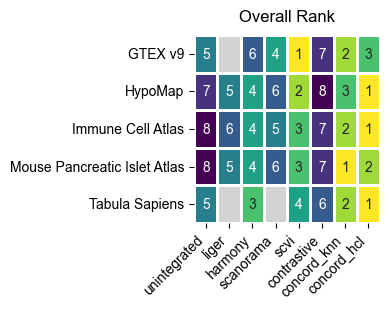

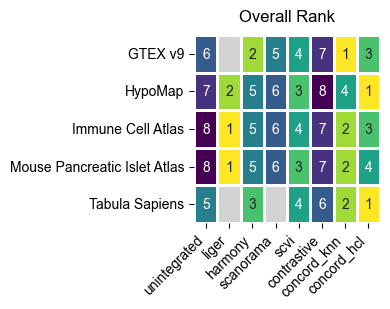

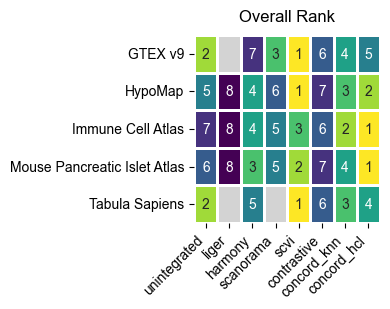

In [33]:
score_keys = [("Aggregate score", "Total"), ("Aggregate score", "Batch correction"), ("Aggregate score", "Bio conservation")]
method_order = [
    "unintegrated", "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]
title = "Overall Rank"

for score_key in score_keys:
    score_dict = {key: metrics_dict[key][score_key] for key in metrics_dict}
    plot_ranked_scores(score_dict,
                       figsize = (len(method_order) * 0.5, len(score_dict) * 0.5 + 0.7),
                       custom_rc=custom_rc,
                       method_order=method_order,
                   title=title,
                   save_dir=save_dir,
                   file_name=f"ranked_{score_key[1]}_{title}_{file_suffix}",
                    save_format="svg"
                   )

### Resource profiling

In [36]:
import re
dataframes = {}
resource_dir = data_dir/"summary_resource_profiling"
for file in resource_dir.glob("*.tsv"):
    if file.name.startswith("._") or file.stat().st_size < 10:
        continue  # Skip hidden/empty files

    # Extract name between 'benchmark_' and '_summary'
    match = re.search(r"benchmark_(.*)_summary", file.stem)
    if match:
        df_name = match.group(1)
    else:
        df_name = file.stem  # fallback

    try:
        dataframes[df_name] = pd.read_csv(file, sep="\t", encoding="utf-8")
    except UnicodeDecodeError:
        try:
            dataframes[df_name] = pd.read_csv(file, sep="\t", encoding="ISO-8859-1")
            print(f"Loaded with fallback encoding: {file.name}")
        except Exception as e:
            print(f"❌ Failed to load {file.name}: {e}")

In [38]:
datasets = dataframes.keys()
methods = sorted(set(
    method
    for df in dataframes.values()
    for method in df["method"]
))
print(f"Datasets: {datasets}")
print(f"Methods: {methods}")

Datasets: dict_keys(['HypoMap_Steuernagel', 'pancreatic_islet_Hrovatin', 'TabulaSapiens_n=300', 'immune_DominguezConde', 'cross_tissue_Eraslan', 'TabulaSapiens'])
Methods: ['concord_hcl', 'concord_knn', 'contrastive', 'harmony', 'liger', 'scanorama', 'scvi']


In [39]:
ram_df = pd.DataFrame(index=methods, columns=datasets)

for dataset, df in dataframes.items():
    df = df.set_index("method")
    ram_df[dataset] = df["ram_MB"]

# save the DataFrame with file suffix in the same directory
ram_df.to_csv(data_dir / f"summary_ram_usage_{file_suffix}.csv")

In [40]:
vram_df = pd.DataFrame(index=methods, columns=datasets)

for dataset, df in dataframes.items():
    df = df.set_index("method")
    vram_df[dataset] = df["vram_MB"]

# save the DataFrame with file suffix in the same directory
vram_df.to_csv(data_dir / f"summary_vram_usage_{file_suffix}.csv")

In [41]:
time_df = pd.DataFrame(index=methods, columns=datasets)
for dataset, df in dataframes.items():
    df = df.set_index("method")
    time_df[dataset] = df["time_sec"]

# save the DataFrame with file suffix in the same directory
time_df.to_csv(data_dir / f"summary_time_usage_{file_suffix}.csv")

In [42]:
from benchmark_utils import plot_resource_usage_heatmap
method_order = [
    "liger", "harmony", "scanorama",
    "scvi", "contrastive", "concord_knn", "concord_hcl"
]

dataset_display_names = {
        "cross_tissue_Eraslan": "GTEX v9",
        "HypoMap_Steuernagel": "HypoMap",
        "pancreatic_islet_Hrovatin": "Mouse Pancreatic Islet Atlas",
        "immune_DominguezConde": "Immune Cell Atlas",
        "TabulaSapiens": "Tabula Sapiens",
        "TabulaSapiens_n=300": "Tabula Sapiens (n=300)",
}


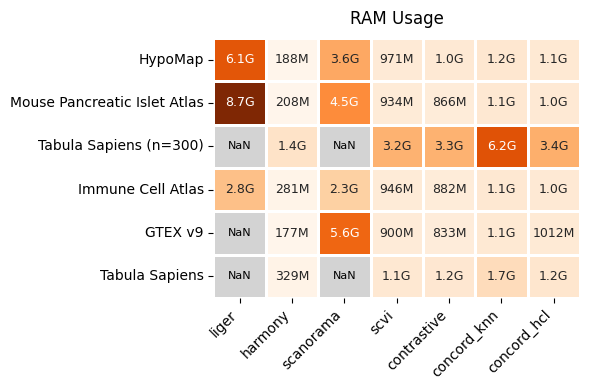

In [43]:
plot_resource_usage_heatmap(ram_df, resource_type="RAM", title="RAM Usage",
                            method_order=method_order,
                            dataset_display_map=dataset_display_names,
                             figsize=(6, 4), 
                             save_dir=save_dir, file_name=f"summary_ram_usage_heatmap_{file_suffix}",
                             save_format="svg")

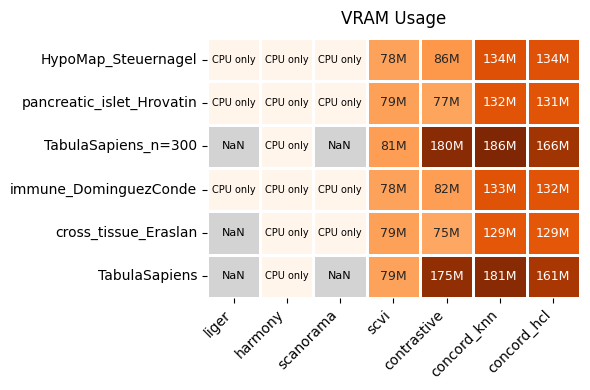

In [44]:
plot_resource_usage_heatmap(vram_df, resource_type="VRAM", title="VRAM Usage",
                            method_order=method_order, 
                            figsize=(6, 4), 
                            save_dir=save_dir, file_name=f"summary_vram_usage_heatmap_{file_suffix}",
                            save_format="svg")

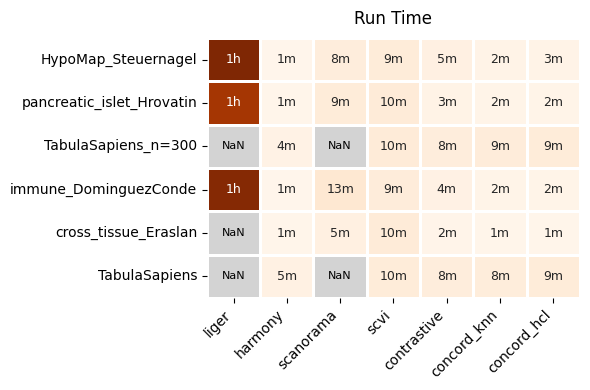

In [45]:
plot_resource_usage_heatmap(time_df, resource_type="Time", title="Run Time",
                            method_order=method_order, 
                            figsize=(6, 4),
                            save_dir=save_dir, file_name=f"summary_time_usage_heatmap_{file_suffix}",
                            save_format="svg")